In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import zipline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('whitegrid')

In [4]:
! set ZIPLINE_ROOT = 'johnr\.zipline'

In [5]:
%load_ext zipline

In [6]:
%%zipline --start 2015-1-1 --end 2018-1-1 --output single_factor.pickle --no-benchmark --bundle quandl

from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
import numpy as np
import pandas as pd

MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 1000


class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())


def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS),
                             'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)


def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')

,period_open,period_close,starting_exposure,net_leverage,ending_exposure,starting_value,ending_value,starting_cash,ending_cash,portfolio_value,...,excess_return,treasury_period_return,trading_days,period_label,algorithm_period_return,algo_volatility,benchmark_period_return,benchmark_volatility,factor_data,prices
2015-01-02 21:00:00+00:00,2015-01-02 14:31:00+00:00,2015-01-02 21:00:00+00:00,0.000,0.000000,0.000,0.000,0.000,1.000000e+07,1.000000e+07,1.000000e+07,...,0.0,0.0,1,2015-01,0.000000,NaN,0.0,NaN,NaN,NaN
2015-01-05 21:00:00+00:00,2015-01-05 14:31:00+00:00,2015-01-05 21:00:00+00:00,0.000,0.000000,0.000,0.000,0.000,1.000000e+07,1.000000e+07,1.000000e+07,...,0.0,0.0,2,2015-01,0.000000,0.000000,0.0,0.0,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-06 21:00:00+00:00,2015-01-06 14:31:00+00:00,2015-01-06 21:00:00+00:00,0.000,0.311545,3114262.860,0.000,3114262.860,1.000000e+07,6.881938e+06,9.996201e+06,...,0.0,0.0,3,2015-01,-0.000380,0.003482,0.0,0.0,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-07 21:00:00+00:00,2015-01-07 14:31:00+00:00,2015-01-07 21:00:00+00:00,3114262.860,0.312429,3127113.440,3114262.860,3127113.440,6.881938e+06,6.881938e+06,1.000905e+07,...,0.0,0.0,4,2015-01,0.000905,0.011564,0.0,0.0,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-08 21:00:00+00:00,2015-01-08 14:31:00+00:00,2015-01-08 21:00:00+00:00,3127113.440,0.316778,3190835.200,3127113.440,3190835.200,6.881938e+06,6.881938e+06,1.007277e+07,...,0.0,0.0,5,2015-01,0.007277,0.044725,0.0,0.0,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,685221.750,0.060637,668261.720,685221.750,668261.720,1.035250e+07,1.035250e+07,1.102076e+07,...,0.0,0.0,751,2017-12,0.102076,0.090139,0.0,0.0,Equity(0 [A]) 2393.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.66 Equity(1 [AA]) ...
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,668261.720,0.056914,624763.750,668261.720,624763.750,1.035250e+07,1.035250e+07,1.097727e+07,...,0.0,0.0,752,2017-12,0.097727,0.090110,0.0,0.0,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,624763.750,-0.115631,-1274086.885,624763.750,-1274086.885,1.035250e+07,1.229260e+07,1.101852e+07,...,0.0,0.0,753,2017-12,0.101852,0.090074,0.0,0.0,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,-1274086.885,-0.107850,-1191100.685,-1274086.885,-1191100.685,1.229260e+07,1.223516e+07,1.104406e+07,...,0.0,0.0,754,2017-12,0.104406,0.090023,0.0,0.0,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...


In [7]:
results = _

In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              755 non-null    datetime64[ns, UTC]
 1   period_close             755 non-null    datetime64[ns, UTC]
 2   starting_exposure        755 non-null    float64            
 3   net_leverage             755 non-null    float64            
 4   ending_exposure          755 non-null    float64            
 5   starting_value           755 non-null    float64            
 6   ending_value             755 non-null    float64            
 7   starting_cash            755 non-null    float64            
 8   ending_cash              755 non-null    float64            
 9   portfolio_value          755 non-null    float64            
 10  returns                  755 non-null    float64 

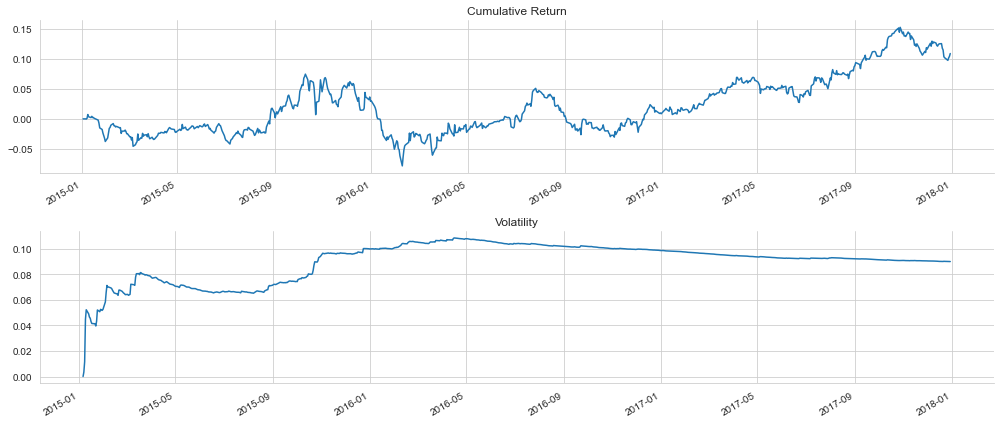

In [9]:
fig, axes = plt.subplots(nrows=2, figsize=(14,6))
results.algorithm_period_return.plot(ax=axes[0], title='Cumulative Return')
results.algo_volatility.plot(ax=axes[1], title='Volatility')
sns.despine()
fig.tight_layout();